In [1]:
#imports the required lib

import os
import requests
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint


In [2]:

DOWNLOAD_DIR = "/content/quickdraw_npy"
os.makedirs(DOWNLOAD_DIR, exist_ok=True)

#list of classes
class_names = [
    'flower', 'bat', 'lightning', 'umbrella', 'dumbbell', 'flip flops', 'bush', 'nail', 'bridge', 'bread',
    'leg', 'tree', 'cow', 'telephone', 'cup', 'bicycle', 'light bulb', 'crown', 'mouth', 'motorbike',
    'tooth', 'school bus', 'cactus', 'spoon', 'camel', 'helicopter', 'river', 'bird', 'butterfly', 'backpack',
    'table', 'hot air balloon', 'camera', 'hat', 'candle', 'bucket', 'beard', 'banana', 'eye', 'sock',
    'book', 'pillow', 'foot', 'flashlight', 'crab', 'fish', 'pencil', 'leaf', 'apple', 'donut'
]

BASE_URL = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"

#download each class as a .npy file
for class_name in tqdm(class_names, desc="Downloading classes"):
    fname_url = class_name.replace(' ', '%20') + ".npy"
    url = BASE_URL + fname_url
    output_path = os.path.join(DOWNLOAD_DIR, class_name.replace(' ', '_') + ".npy")

    if not os.path.exists(output_path):
        try:
            r = requests.get(url)
            r.raise_for_status()
            with open(output_path, 'wb') as f:
                f.write(r.content)
        except Exception as e:
            print(f"Failed to download {class_name}: {e}")


In [3]:
IMG_SIZE = 128
SAMPLES_PER_CLASS = 2000
IMG_ROOT = "/content/quickdraw_images"

#covert the .npy file to images (.png)
os.makedirs(IMG_ROOT, exist_ok=True)

for class_name in tqdm(class_names, desc="Converting to PNG"):
    clean_name = class_name.replace(" ", "_")
    class_dir = os.path.join(IMG_ROOT, clean_name)
    os.makedirs(class_dir, exist_ok=True)

    file_path = os.path.join(DOWNLOAD_DIR, clean_name + ".npy")
    data = np.load(file_path)[:SAMPLES_PER_CLASS]

    for i, img in enumerate(data):
        img = img.reshape(28, 28).astype(np.uint8)
        img = Image.fromarray(img).resize((IMG_SIZE, IMG_SIZE)).convert("RGB")
        img.save(os.path.join(class_dir, f"{i}.png"))


Converting to PNG: 100%|██████████| 50/50 [03:24<00:00,  4.09s/it]


In [4]:
BATCH_SIZE = 64

#data genrators and  data augmentations
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

train_gen = datagen.flow_from_directory(
    IMG_ROOT,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    IMG_ROOT,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 85000 images belonging to 50 classes.
Found 15000 images belonging to 50 classes.


In [ ]:
#defining our model (pretrained)
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))  #using imagenet pretrained weights
base_model.trainable = False   #frezzing all the layers

#model hyperparameter
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        12,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,858,866 (56.68 MB)

 Trainable params: 144,178 (563.20 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint(
    'best_vgg16_50c_2k.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

In [ ]:

#model trianing with freezed layers
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.1141 - loss: 3.6627
Epoch 1: val_accuracy improved from -inf to 0.50787, saving model to best_vgg16_50c_2k.h5


1329/1329 ━━━━━━━━━━━━━━━━━━━━ 527s 387ms/step - accuracy: 0.1142 - loss: 3.6625 - val_accuracy: 0.5079 - val_loss: 2.5622 - learning_rate: 1.0000e-04
Epoch 2/15
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.3796 - loss: 2.5327
Epoch 2: val_accuracy improved from 0.50787 to 0.58720, saving model to best_vgg16_50c_2k.h5


1329/1329 ━━━━━━━━━━━━━━━━━━━━ 487s 366ms/step - accuracy: 0.3796 - loss: 2.5326 - val_accuracy: 0.5872 - val_loss: 1.9159 - learning_rate: 1.0000e-04
Epoch 3/15
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.4805 - loss: 2.0425
Epoch 3: val_accuracy improved from 0.58720 to 0.62427, saving model to best_vgg16_50c_2k.h5


1329/1329 ━━━━━━━━━━━━━━━━━━━━ 484s 364ms/step - accuracy: 0.4805 - loss: 2.0425 - val_accuracy: 0.6243 - val_loss: 1.6277 - learning_rate: 1.0000e-04
Epoch 4/15
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.5318 - loss: 1.8036
Epoch 4: val_accuracy improved from 0.62427 to 0.64953, saving model to best_vgg16_50c_2k.h5


1329/1329 ━━━━━━━━━━━━━━━━━━━━ 478s 360ms/step - accuracy: 0.5318 - loss: 1.8036 - val_accuracy: 0.6495 - val_loss: 1.4643 - learning_rate: 1.0000e-04
Epoch 5/15
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.5634 - loss: 1.6608
Epoch 5: val_accuracy improved from 0.64953 to 0.66880, saving model to best_vgg16_50c_2k.h5


1329/1329 ━━━━━━━━━━━━━━━━━━━━ 476s 358ms/step - accuracy: 0.5634 - loss: 1.6608 - val_accuracy: 0.6688 - val_loss: 1.3495 - learning_rate: 1.0000e-04
Epoch 6/15
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.5967 - loss: 1.5521
Epoch 6: val_accuracy improved from 0.66880 to 0.67927, saving model to best_vgg16_50c_2k.h5


1329/1329 ━━━━━━━━━━━━━━━━━━━━ 475s 358ms/step - accuracy: 0.5967 - loss: 1.5521 - val_accuracy: 0.6793 - val_loss: 1.2785 - learning_rate: 1.0000e-04
Epoch 7/15
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.6105 - loss: 1.4694
Epoch 7: val_accuracy improved from 0.67927 to 0.69293, saving model to best_vgg16_50c_2k.h5


1329/1329 ━━━━━━━━━━━━━━━━━━━━ 476s 358ms/step - accuracy: 0.6105 - loss: 1.4693 - val_accuracy: 0.6929 - val_loss: 1.2242 - learning_rate: 1.0000e-04
Epoch 8/15
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.6260 - loss: 1.4082
Epoch 8: val_accuracy improved from 0.69293 to 0.70127, saving model to best_vgg16_50c_2k.h5


1329/1329 ━━━━━━━━━━━━━━━━━━━━ 476s 359ms/step - accuracy: 0.6260 - loss: 1.4082 - val_accuracy: 0.7013 - val_loss: 1.1772 - learning_rate: 1.0000e-04
Epoch 9/15
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.6388 - loss: 1.3606
Epoch 9: val_accuracy improved from 0.70127 to 0.70720, saving model to best_vgg16_50c_2k.h5


1329/1329 ━━━━━━━━━━━━━━━━━━━━ 506s 361ms/step - accuracy: 0.6388 - loss: 1.3606 - val_accuracy: 0.7072 - val_loss: 1.1417 - learning_rate: 1.0000e-04
Epoch 10/15
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.6489 - loss: 1.3232
Epoch 10: val_accuracy improved from 0.70720 to 0.71440, saving model to best_vgg16_50c_2k.h5


1329/1329 ━━━━━━━━━━━━━━━━━━━━ 487s 367ms/step - accuracy: 0.6489 - loss: 1.3232 - val_accuracy: 0.7144 - val_loss: 1.1055 - learning_rate: 1.0000e-04
Epoch 11/15
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.6540 - loss: 1.2955
Epoch 11: val_accuracy improved from 0.71440 to 0.72200, saving model to best_vgg16_50c_2k.h5


1329/1329 ━━━━━━━━━━━━━━━━━━━━ 476s 358ms/step - accuracy: 0.6540 - loss: 1.2955 - val_accuracy: 0.7220 - val_loss: 1.0778 - learning_rate: 1.0000e-04
Epoch 12/15
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.6635 - loss: 1.2649
Epoch 12: val_accuracy did not improve from 0.72200
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 499s 356ms/step - accuracy: 0.6635 - loss: 1.2649 - val_accuracy: 0.7211 - val_loss: 1.0605 - learning_rate: 1.0000e-04
Epoch 13/15
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.6651 - loss: 1.2480
Epoch 13: val_accuracy improved from 0.72200 to 0.72793, saving model to best_vgg16_50c_2k.h5


1329/1329 ━━━━━━━━━━━━━━━━━━━━ 486s 365ms/step - accuracy: 0.6652 - loss: 1.2480 - val_accuracy: 0.7279 - val_loss: 1.0411 - learning_rate: 1.0000e-04
Epoch 14/15
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.6784 - loss: 1.2155
Epoch 14: val_accuracy improved from 0.72793 to 0.73360, saving model to best_vgg16_50c_2k.h5


1329/1329 ━━━━━━━━━━━━━━━━━━━━ 479s 361ms/step - accuracy: 0.6784 - loss: 1.2155 - val_accuracy: 0.7336 - val_loss: 1.0239 - learning_rate: 1.0000e-04
Epoch 15/15
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.6830 - loss: 1.2054
Epoch 15: val_accuracy improved from 0.73360 to 0.73647, saving model to best_vgg16_50c_2k.h5


1329/1329 ━━━━━━━━━━━━━━━━━━━━ 475s 358ms/step - accuracy: 0.6830 - loss: 1.2053 - val_accuracy: 0.7365 - val_loss: 1.0053 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 15.


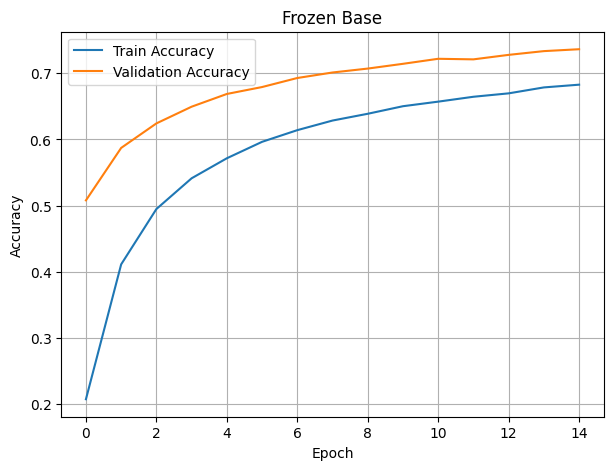

In [ ]:
#plotting the model performace with freezed base (whole layers freezed)
def plot_history(history, title="Frozen Base"):
    plt.figure(figsize=(7,5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function with the frozen base model history
plot_history(history, "Frozen Base")


In [ ]:
#Unfreezing the  block5 (fine tuning for better performance)
#increased the no of learnable weights or parameters

for layer in base_model.layers:
    if 'block5' in layer.name:
        layer.trainable = True
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        12,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,858,866 (56.68 MB)

 Trainable params: 7,223,602 (27.56 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:


model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_checkpoint = ModelCheckpoint("vgg16_finetuned_best.h5", save_best_only=True, monitor="val_accuracy", mode="max")

#model training again with fine tuning
history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=8,
    callbacks=[fine_tune_checkpoint]
)


Epoch 1/8
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.7190 - loss: 1.0405

1329/1329 ━━━━━━━━━━━━━━━━━━━━ 505s 375ms/step - accuracy: 0.7190 - loss: 1.0404 - val_accuracy: 0.8008 - val_loss: 0.7298
Epoch 2/8
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.7766 - loss: 0.8273

1329/1329 ━━━━━━━━━━━━━━━━━━━━ 487s 367ms/step - accuracy: 0.7766 - loss: 0.8273 - val_accuracy: 0.8201 - val_loss: 0.6535
Epoch 3/8
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.8076 - loss: 0.7239

1329/1329 ━━━━━━━━━━━━━━━━━━━━ 504s 369ms/step - accuracy: 0.8076 - loss: 0.7239 - val_accuracy: 0.8365 - val_loss: 0.6088
Epoch 4/8
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.8192 - loss: 0.6799

1329/1329 ━━━━━━━━━━━━━━━━━━━━ 500s 367ms/step - accuracy: 0.8192 - loss: 0.6799 - val_accuracy: 0.8439 - val_loss: 0.5782
Epoch 5/8
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.8324 - loss: 0.6265

1329/1329 ━━━━━━━━━━━━━━━━━━━━ 498s 375ms/step - accuracy: 0.8324 - loss: 0.6265 - val_accuracy: 0.8462 - val_loss: 0.5569
Epoch 6/8
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.8432 - loss: 0.5861

1329/1329 ━━━━━━━━━━━━━━━━━━━━ 497s 374ms/step - accuracy: 0.8432 - loss: 0.5861 - val_accuracy: 0.8573 - val_loss: 0.5363
Epoch 7/8
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 493s 371ms/step - accuracy: 0.8501 - loss: 0.5529 - val_accuracy: 0.8566 - val_loss: 0.5254
Epoch 8/8
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.8581 - loss: 0.5245

1329/1329 ━━━━━━━━━━━━━━━━━━━━ 499s 369ms/step - accuracy: 0.8581 - loss: 0.5245 - val_accuracy: 0.8608 - val_loss: 0.5166


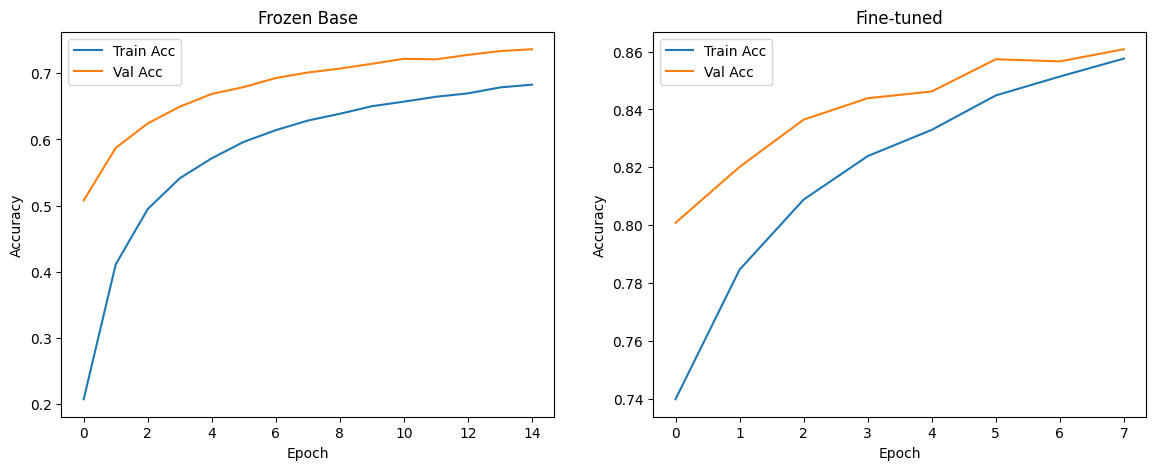

In [ ]:

def plot_history(histories, titles):
    plt.figure(figsize=(14,5))

    for i, (hist, title) in enumerate(zip(histories, titles)):
        plt.subplot(1, 2, i+1)
        plt.plot(hist.history['accuracy'], label='Train Acc')
        plt.plot(hist.history['val_accuracy'], label='Val Acc')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.show()

plot_history([history, history_finetune], ["Frozen Base","Fine-tuned"])

In [ ]:
fine_tune_checkpoint = ModelCheckpoint("vgg16_finetuned_best.h5", save_best_only=True, monitor="val_accuracy", mode="max")
#fine tuned further for more epoch
history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=[fine_tune_checkpoint]
)


Epoch 1/5
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.8652 - loss: 0.4929

1329/1329 ━━━━━━━━━━━━━━━━━━━━ 494s 371ms/step - accuracy: 0.8652 - loss: 0.4929 - val_accuracy: 0.8641 - val_loss: 0.5073
Epoch 2/5
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.8698 - loss: 0.4740

1329/1329 ━━━━━━━━━━━━━━━━━━━━ 492s 370ms/step - accuracy: 0.8698 - loss: 0.4740 - val_accuracy: 0.8658 - val_loss: 0.4987
Epoch 3/5
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 488s 367ms/step - accuracy: 0.8736 - loss: 0.4573 - val_accuracy: 0.8638 - val_loss: 0.5018
Epoch 4/5
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.8792 - loss: 0.4422

1329/1329 ━━━━━━━━━━━━━━━━━━━━ 518s 379ms/step - accuracy: 0.8792 - loss: 0.4422 - val_accuracy: 0.8677 - val_loss: 0.4900
Epoch 5/5
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.8810 - loss: 0.4297

1329/1329 ━━━━━━━━━━━━━━━━━━━━ 493s 371ms/step - accuracy: 0.8810 - loss: 0.4297 - val_accuracy: 0.8681 - val_loss: 0.4861


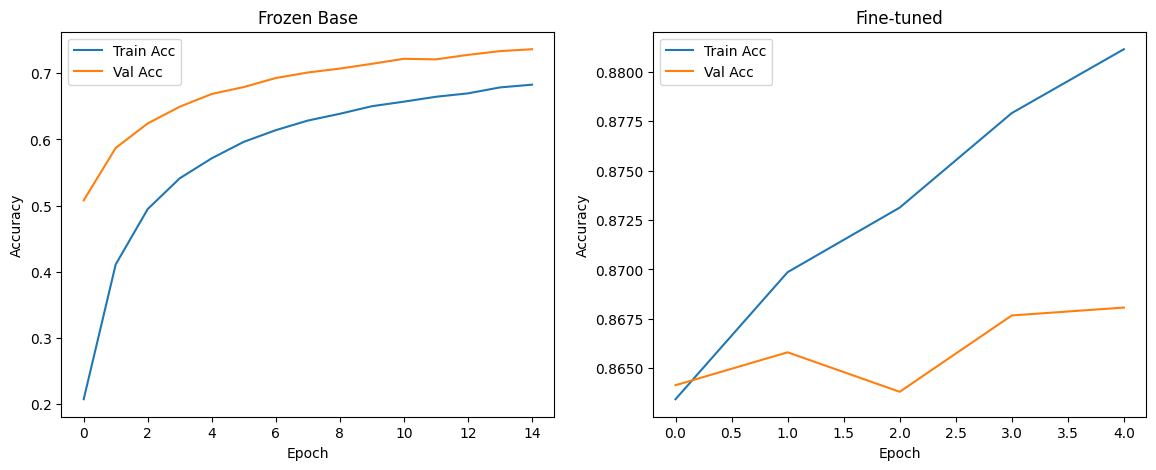

In [ ]:
#plotting the performace for fine tuning
def plot_history(histories, titles):
    plt.figure(figsize=(14,5))

    for i, (hist, title) in enumerate(zip(histories, titles)):
        plt.subplot(1, 2, i+1)
        plt.plot(hist.history['accuracy'], label='Train Acc')
        plt.plot(hist.history['val_accuracy'], label='Val Acc')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.show()

plot_history([history, history_finetune], ["Frozen Base","Fine-tuned"])

In [ ]:
fine_tune_checkpoint = ModelCheckpoint("vgg16_finetuned_best.h5", save_best_only=True, monitor="val_accuracy", mode="max")
#further training of model
history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=2,
    callbacks=[fine_tune_checkpoint]
)


Epoch 1/2
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.8864 - loss: 0.4074

1329/1329 ━━━━━━━━━━━━━━━━━━━━ 489s 368ms/step - accuracy: 0.8864 - loss: 0.4074 - val_accuracy: 0.8673 - val_loss: 0.4922
Epoch 2/2
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.8893 - loss: 0.3928

1329/1329 ━━━━━━━━━━━━━━━━━━━━ 485s 365ms/step - accuracy: 0.8893 - loss: 0.3928 - val_accuracy: 0.8711 - val_loss: 0.4891


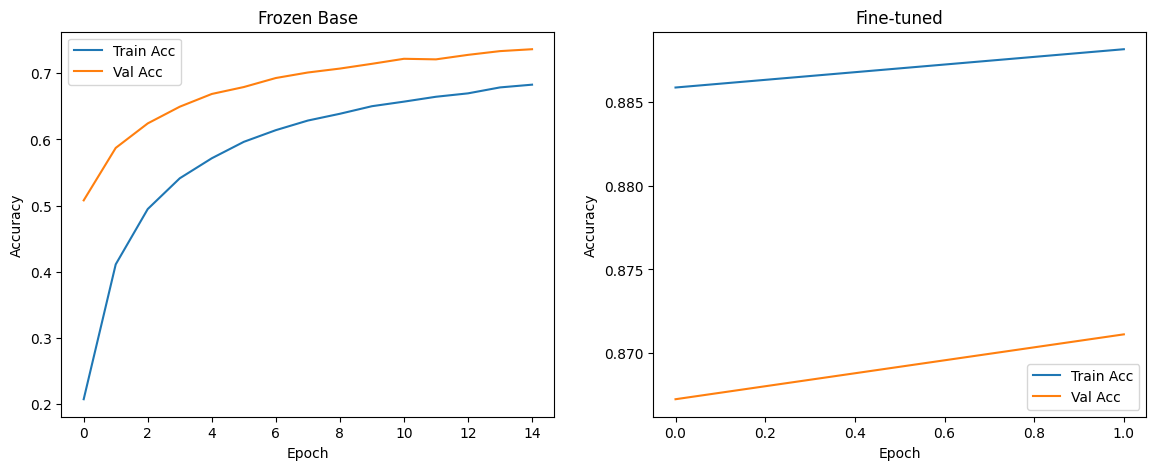

In [ ]:

def plot_history(histories, titles):
    plt.figure(figsize=(14,5))

    for i, (hist, title) in enumerate(zip(histories, titles)):
        plt.subplot(1, 2, i+1)
        plt.plot(hist.history['accuracy'], label='Train Acc')
        plt.plot(hist.history['val_accuracy'], label='Val Acc')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.show()

plot_history([history, history_finetune], ["Frozen Base","Fine-tuned"])

In [ ]:
print(train_gen.class_indices) # prints the mapping used for classes in training

{'apple': 0, 'backpack': 1, 'banana': 2, 'bat': 3, 'beard': 4, 'bicycle': 5, 'bird': 6, 'book': 7, 'bread': 8, 'bridge': 9, 'bucket': 10, 'bush': 11, 'butterfly': 12, 'cactus': 13, 'camel': 14, 'camera': 15, 'candle': 16, 'cow': 17, 'crab': 18, 'crown': 19, 'cup': 20, 'donut': 21, 'dumbbell': 22, 'eye': 23, 'fish': 24, 'flashlight': 25, 'flip_flops': 26, 'flower': 27, 'foot': 28, 'hat': 29, 'helicopter': 30, 'hot_air_balloon': 31, 'leaf': 32, 'leg': 33, 'light_bulb': 34, 'lightning': 35, 'motorbike': 36, 'mouth': 37, 'nail': 38, 'pencil': 39, 'pillow': 40, 'river': 41, 'school_bus': 42, 'sock': 43, 'spoon': 44, 'table': 45, 'telephone': 46, 'tooth': 47, 'tree': 48, 'umbrella': 49}


In [6]:
#setup for inference
import os
import numpy as np
from PIL import Image
import random
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from time import perf_counter

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Constants
IMG_SIZE = 128
N_IMAGES = 20
MODEL_PATH = "/content/vgg16_50c_2k.h5"
NPY_DIR = "/content/quickdraw_npy"
INFER_DIR = "/content/inference_images"

# Class mapping
class_indices = {
    'apple': 0, 'backpack': 1, 'banana': 2, 'bat': 3, 'beard': 4, 'bicycle': 5, 'bird': 6, 'book': 7, 'bread': 8, 'bridge': 9,
    'bucket': 10, 'bush': 11, 'butterfly': 12, 'cactus': 13, 'camel': 14, 'camera': 15, 'candle': 16, 'cow': 17, 'crab': 18,
    'crown': 19, 'cup': 20, 'donut': 21, 'dumbbell': 22, 'eye': 23, 'fish': 24, 'flashlight': 25, 'flip_flops': 26, 'flower': 27,
    'foot': 28, 'hat': 29, 'helicopter': 30, 'hot_air_balloon': 31, 'leaf': 32, 'leg': 33, 'light_bulb': 34, 'lightning': 35,
    'motorbike': 36, 'mouth': 37, 'nail': 38, 'pencil': 39, 'pillow': 40, 'river': 41, 'school_bus': 42, 'sock': 43, 'spoon': 44,
    'table': 45, 'telephone': 46, 'tooth': 47, 'tree': 48, 'umbrella': 49
}

class_names = [name.replace("_", " ") for name, _ in sorted(class_indices.items(), key=lambda x: x[1])]


In [7]:

#Convert .npy to Images

selected_classes = random.sample(list(class_indices.keys()), 50)

os.makedirs(INFER_DIR, exist_ok=True)

for class_key in selected_classes:
    npy_path = os.path.join(NPY_DIR, class_key + ".npy")
    data = np.load(npy_path)[:N_IMAGES]
    class_dir = os.path.join(INFER_DIR, class_key)
    os.makedirs(class_dir, exist_ok=True)

    for i, img in enumerate(data):
        img = img.reshape(28, 28).astype(np.uint8)
        img = Image.fromarray(img).resize((IMG_SIZE, IMG_SIZE)).convert("RGB")
        img.save(os.path.join(class_dir, f"{i}.png"))

print(f"\nSaved {N_IMAGES} images each for: {[c.replace('_', ' ') for c in selected_classes]}")



Saved 20 images each for: ['bread', 'bucket', 'butterfly', 'fish', 'hat', 'flip flops', 'crab', 'cup', 'donut', 'backpack', 'flashlight', 'spoon', 'banana', 'sock', 'helicopter', 'crown', 'lightning', 'foot', 'tree', 'table', 'cow', 'bat', 'bush', 'pencil', 'river', 'umbrella', 'hot air balloon', 'apple', 'leg', 'camel', 'pillow', 'cactus', 'light bulb', 'candle', 'camera', 'school bus', 'mouth', 'bird', 'motorbike', 'eye', 'bicycle', 'leaf', 'flower', 'book', 'bridge', 'telephone', 'beard', 'dumbbell', 'tooth', 'nail']


In [8]:

#Load Model our model

model = load_model(MODEL_PATH)
print("Model loaded successfully.")


Model loaded successfully.


In [9]:

#prepare  Data Generator

infer_datagen = ImageDataGenerator(rescale=1./255)

inference_gen = infer_datagen.flow_from_directory(
    INFER_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode=None,
    shuffle=False
)


Found 1000 images belonging to 50 classes.


In [10]:

#inference time calculations


@tf.function
def infer(x):
    return model(x)

_ = infer(inference_gen[0])

#Measure inference times (excluding first image)
inference_times = []

for i in range(1, len(inference_gen)):
    batch = inference_gen[i]
    start = perf_counter()
    _ = infer(batch)
    end = perf_counter()
    inference_times.append((end - start) * 1000)

avg_time = np.mean(inference_times)
print(f"Inference Time per Image (excluding warm-up): {avg_time:.2f} ms")


Inference Time per Image (excluding warm-up): 3.57 ms


In [ ]:

#Show Predictions for the images made by the model

predicted_labels = []

for i in range(len(inference_gen)):
    batch = inference_gen[i]
    preds = model.predict(batch, verbose=0)
    pred_idx = np.argmax(preds[0])
    pred_label = class_names[pred_idx]
    predicted_labels.append(pred_label)

    img = image.array_to_img(batch[0])
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {pred_label}")
    plt.show()
